# Task 2
## Conecta 4 con Temporal Difference Learning
### Integrantes:
- Diego Leiva
- Marta Ramirez
- Gustavo Gonzales
- Pablo Orellana

**Importar librerias necesarias**

In [1]:
from kaggle_environments import evaluate, make
import matplotlib.pyplot as plt
import numpy as np
import random
import time

**Crear un entorno de Conecta 4**

In [2]:
env = make("connectx", configuration={'timeout': 10}, debug=True)
env.render(mode="ipython")
env.configuration

{'timeout': 10, 'columns': 7, 'rows': 6, 'inarow': 4, 'steps': 1000}

### AGENTES MINIMAX

**AGENTE MINIMAX SIN PODA**

Definir funciones de evaluacion de ventana

In [3]:
def check_window(window, num_discs, piece, config):
    """
    Comprueba si una ventana contiene el número especificado de discos de una pieza dada.

    Args:
        window (list): La ventana a comprobar.
        num_discs (int): El número de discos en la ventana.
        piece (int): La pieza del jugador (1 o 2).
        config (Config): La configuración del juego.

    Returns:
        bool: Verdadero si la ventana contiene el número especificado de discos de la pieza dada, Falso en caso contrario.
    """
    if window.count(piece) == num_discs and window.count(0) == config.inarow - num_discs:
        return True
    else:
        return False 

In [4]:
def count_windows(grid, num_discs, piece, config):
    """
    Cuenta el número de ventanas en la cuadrícula que contienen cierto número de discos de una pieza dada.

    Args:
        grid (numpy.ndarray): La cuadrícula del juego.
        num_discs (int): El número de discos en una ventana.
        piece (int): La pieza del jugador (1 o 2).
        config (Config): La configuración del juego.

    Returns:
        int: El número de ventanas.
    """
    num_windows = 0

    # horizontal
    for row in range(config.rows):
        for col in range(config.columns - (config.inarow - 1)):
            window = list(grid[row, col:col + config.inarow])
            if check_window(window, num_discs, piece, config):
                num_windows += 1

    # vertical
    for row in range(config.rows - (config.inarow - 1)):
        for col in range(config.columns):
            window = list(grid[row:row + config.inarow, col])
            if check_window(window, num_discs, piece, config):
                num_windows += 1

    # diagonal con pendiente positiva
    for row in range(config.rows - (config.inarow - 1)):
        for col in range(config.columns - (config.inarow - 1)):
            window = list(grid[range(row, row + config.inarow), range(col, col + config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1

    # diagonal con pendiente negativa
    for row in range(config.inarow - 1, config.rows):
        for col in range(config.columns - (config.inarow - 1)):
            window = list(grid[range(row, row - config.inarow, -1), range(col, col + config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    return num_windows



Definir la heuristica a utilizar

In [5]:
def get_heuristic(grid, mark, config):
    """
    Calcula la puntuación heurística para un estado de cuadrícula dado.

    Args:
        grid (numpy.ndarray): La cuadrícula del juego.
        mark (int): La marca del jugador (1 o 2).
        config (Config): La configuración del juego.

    Returns:
        int: La puntuación heurística.
    """
    score = 0
    for i in range(config.inarow):
        num = count_windows(grid, i + 1, mark, config)
        score += (4 ** (i + 1)) * num
    for i in range(config.inarow):
        num_opp = count_windows(grid, i + 1, mark % 2 + 1, config)
        score -= (2 ** ((2 * i) + 3)) * num_opp
    return score


Definir funciones auxiliares

In [6]:
def drop_piece(grid, col, piece, config):
    """
    Inserta una pieza en la columna especificada de la cuadrícula del juego.

    Args:
        grid (numpy.ndarray): La cuadrícula del juego.
        col (int): La columna donde insertar la pieza.
        piece (int): La pieza del jugador (1 o 2).
        config (Config): La configuración del juego.

    Returns:
        numpy.ndarray: La cuadrícula del juego actualizada.
    """
    next_grid = grid.copy()
    for row in range(config.rows-1, -1, -1):
        if next_grid[row][col] == 0:
            break
    next_grid[row][col] = piece
    return next_grid

Implementar el algoritmo de minimax

In [7]:
def score_move_a(grid, col, mark, config, max_depth=1):
    """
    Calcula la puntuación para un movimiento en la cuadrícula del juego utilizando la función score_move_b.

    Args:
        grid (numpy.ndarray): La cuadrícula del juego.
        col (int): La columna en la que hacer el movimiento.
        mark (int): La marca del jugador (1 o 2).
        config (Config): La configuración del juego.
        max_depth (int, opcional): El número de pasos para mirar hacia adelante (Profundidad del arbol). Por defecto es 1.

    Returns:
        int: La puntuación para el movimiento.
    """
    next_grid = drop_piece(grid, col, mark, config)
    valid_moves = [col for col in range(config.columns) if next_grid[0][col] == 0]
    if len(valid_moves) == 0 or max_depth == 0:
        score = get_heuristic(next_grid, mark, config)
        return score
    else:
        scores = [score_move_b(next_grid, col, mark, config, max_depth - 1) for col in valid_moves]
        score = min(scores)
    return score


def score_move_b(grid, col, mark, config, max_depth):
    """
    Calcula la puntuación para un movimiento en la cuadrícula del juego utilizando la función score_move_a.

    Args:
        grid (numpy.ndarray): La cuadrícula del juego.
        col (int): La columna en la que hacer el movimiento.
        mark (int): La marca del jugador (1 o 2).
        config (Config): La configuración del juego.
        max_depth (int): El número de pasos a mirar hacia adelante (profundidad del arbol).

    Returns:
        int: La puntuación para el movimiento.
    """
    next_grid = drop_piece(grid, col, (mark % 2) + 1, config)
    valid_moves = [col for col in range(config.columns) if next_grid[0][col] == 0]
    if len(valid_moves) == 0 or max_depth == 0:
        score = get_heuristic(next_grid, mark, config)
        return score
    else:
        scores = [score_move_a(next_grid, col, mark, config, max_depth - 1) for col in valid_moves]
        score = max(scores)
    return score

**Definir el agente minimax**

In [8]:
def minimax_agent(obs, config):
    """
    Implementacion de un agente minimax sin poda para el juego conecta 4.

    Args:
        obs: Un objeto representando el estado actual del juego.
        config: Un objeto con los parametros de configuracion del juego.

    Returns:
        La columna que selecciono el agente para colocar su ficha.
    """
    valid_moves = [c for c in range(config.columns) if obs.board[c] == 0]
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    scores = dict(zip(valid_moves, [score_move_a(grid=grid, col=col, mark=obs.mark, config=config, max_depth=1) for col in valid_moves]))
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]
    return random.choice(max_cols)

**Probar el funcionamiento del agenete contra un agente aleatorio**

Antes de hacer la prueba es necesario aclarar algunas cosas del entorno ConnectX de la API de Kaggle
1. el comando **'run'** lleva ["Jugador 1", "Jugador 2"]
2. Jugador 1 es representado por la ficha celeste con una 'K'
3. Jugador 2 es representado por la ficha gris con un 'pato'
4. El jugador 1 siempre va primero

In [9]:
# Usar el agente minimax contra un agente aleatorio
env.run([minimax_agent,"random"])

env.render(mode="ipython")

Claramente el agente minimax no tuvo problema alguno para vencer al agente aleatorio

Codigo de referencia obtenido de:
- https://www.kaggle.com/code/sidagar/getting-1000-score-using-only-minimax
- https://www.kaggle.com/code/alexisbcook/one-step-lookahead

**Evaluando el modelo**

In [10]:
def win_rate(rewards):
    """
    Calcula la tasa de victoria basada en una lista de recompensas.

    Args:
        rewards (lista): Una lista de tuplas que representan las recompensas para cada juego jugado. Cada tupla contiene dos valores: el número de victorias y el número de derrotas.

    Returns:
        tupla: Una tupla que contiene la tasa de victoria como porcentaje para victorias y derrotas.
    """
    return sum(r[0] for r in rewards) / float(len(rewards)) * 100, sum(r[1] for r in rewards) / float(len(rewards)) * 100, 

In [11]:
def plot_win_count(win_rate1, agent1, win_rate2, agent2, episodes):
    """
    Grafica la cantidad de victorias de cada agente en el jeugo de conecta 4.

    Args:
        win_rate1 (float): Taza de exito del agente 1.
        agent1 (str): El nombre del agente 1.
        win_rate2 (float): Taza de exito del agente 2.
        agent2 (str): El nombre del agente 2.
        episodes (int): Cantidad total de iteraciones.

    Returns:
        None
    """
    # Calcula el conteo de victorias
    win_count1 = win_rate1 / 100 * episodes
    win_count2 = win_rate2 / 100 * episodes

    # Crea un gráfico de barras
    plt.bar([agent1, agent2], [win_count1, win_count2])
    plt.ylabel('Cantidad de Victorias')
    plt.title('Conteo de victorias para 2 agentes')

    # Muestra el gráfico
    plt.show()

In [12]:
# Mostrar los resultados
win_rate_1, win_rate_2 = win_rate(evaluate("connectx", [minimax_agent, "random"], num_episodes=10))
print("Taza de éxito para el agente Minimax: ", win_rate_1, "%")
print("Taza de éxito para el agente Aleatorio: ", win_rate_2, "%")

Taza de éxito para el agente Minimax:  100.0 %
Taza de éxito para el agente Aleatorio:  0.0 %


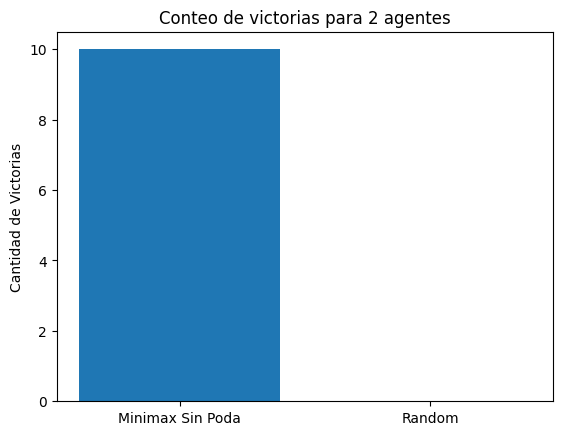

In [13]:
# Graficar los resultados
plot_win_count(win_rate_1, "Minimax Sin Poda", win_rate_2, "Random", 10)

In [14]:
# Mostrar los resultados
win_rate_1, win_rate_2 = win_rate(evaluate("connectx", [minimax_agent, "negamax"], num_episodes=10))
print("Taza de éxito para el agente Minimax: ", win_rate_1, "%")
print("Taza de éxito para el agente Negamax: ", win_rate_2, "%")

Taza de éxito para el agente Minimax:  65.0 %
Taza de éxito para el agente Negamax:  35.0 %


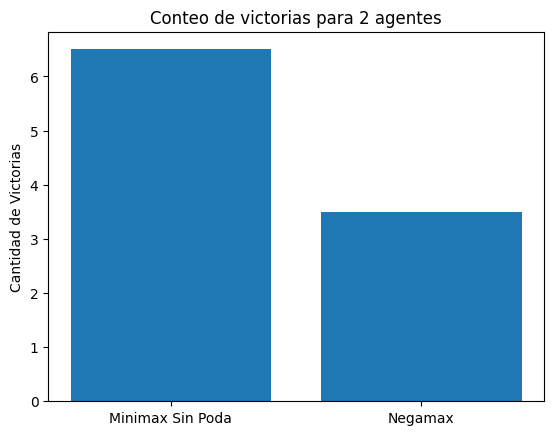

In [15]:
# Graficar los resultados
plot_win_count(win_rate_1, "Minimax Sin Poda", win_rate_2, "Negamax", 10)

**AGENTE MINIMAX CON ALPHA-BETA PRUNING**

**Definir el agente minimax con alpha-beta pruning**

In [16]:
def minimax_agent_alpha_beta(obs, config):
    """
    Implementacion de un agente minimax con poda alpha-beta para el juego conecta 4.

    Args:
        obs: Un objeto representando el estado actual del juego.
        config: Un objeto con los parametros de configuracion del juego.

    Returns:
        La columna que selecciono el agente para colocar su ficha.
    """
    start_time = time.time()
    columns = config.columns
    rows = config.rows
    inarow = config.inarow
    board = obs.board
    piece = obs.mark
    boardarray = np.array(board).reshape(rows, columns).tolist()
    inf = np.inf
    nodesExpanded = 0
    depth = 0
    maxDepth = 1
    timeAmount = config.timeout - 1
    
    class ConnectBoard(object):
        """
        Representa un tablero de juego de Cuatro en Línea.

        Atributos:
            board (lista): El estado actual del tablero.
            columns (int): El número de columnas en el tablero.
            rows (int): El número de filas en el tablero.
            mark (int): La marca que se colocará en el tablero.
            inarow (int): El número de marcas necesarias en fila para ganar.
            depth (int): La profundidad del árbol que ha sido expandido hasta el momento.
            parent (ConnectBoard): El tablero padre del que proviene este tablero.
            indexNum (int): El índice de la pieza que acaba de ser colocada.
        """

        def __init__(self, board, columns, rows, mark, inarow, depth=0, parent=None, indexNum=None):
            self.board = board
            self.columns = columns
            self.rows = rows
            self.mark = mark
            self.inarow = inarow
            self.depth = depth
            self.parent = parent
            self.indexNum = indexNum
            

        def getMoves(self):
            """
            Obtiene todos los movimientos posibles verificando si la parte superior del tablero está vacía para cada columna.

            Returns:
                list: Una lista de los movimientos posibles representados por el número de columna.
            """
            moves = []
            if len(moves) == 0:
                for col in range(self.columns):
                    if self.board[0][col] == 0:
                        moves.append(col)
            return moves
        
        
        def evaluate(self):
            """
            Evalúa el tablero y devuelve una puntuación que indica el favoritismo hacia el jugador 1 o el jugador 2.
            Un valor positivo indica favoritismo hacia el jugador 1, un valor negativo indica favoritismo hacia el jugador 2,
            y un valor de infinito indica que un jugador ha ganado.

            Returns:
                score (float): Puntuación que evalúa el tablero.
            """
            score = 0

            # cuánto más peso debería tener una secuencia más larga de fichas sobre una más corta (por ejemplo, 3 en línea es [branchConstant] veces más importante que 2 en línea)
            branchConstant = 6

            # listas de piezas en el tablero que son beneficiosas para cada jugador respectivo (por ejemplo, el jugador 1 puede tener 0 o 1, el jugador 2 puede tener 0 o 2)
            allowed = [[0, self.mark], [0, 3 - self.mark]]
            
            # código que cuenta las marcas de cada lado para determinar qué jugador mueve a continuación
            playerTurn = 0
            for row in range(self.rows):
                for col in range(self.columns):
                    if self.board[row][col] == 1:
                        playerTurn += 1
                    elif self.board[row][col] == 2:
                        playerTurn -= 1
            playerTurn += 1
            
            
            # verifica las condiciones para ambos jugadores para compararlos
            for turn in range(len(allowed)):
                # itera sobre las filas de abajo hacia arriba
                for row in range(self.rows - 1, -1, -1):
                    # itera sobre las columnas
                    for col in range(self.columns):
                        # verifica ciertas condiciones en los patrones:línea vertical, línea horizontal, diagonal 1 y diagonal 2
                        # consistencia: cuánto de una línea está llena de 0 o la marca del jugador
                        
                        # líneas verticales
                        if row < self.rows - (self.inarow - 1):
                            consistency = 0
                            
                            for inc in range(self.inarow):
                                if self.board[row + inc][col] in allowed[turn]:
                                    consistency += 1

                            if consistency == self.inarow:
                                consistency = 0
                                
                                for inc2 in range(self.inarow):
                                    consistency += allowed[turn].index(self.board[row + inc2][col])
                               
                                # agrega puntaje
                                score += branchConstant ** consistency if turn == 0 else -1 * branchConstant ** consistency
                                
                                if consistency == self.inarow:
                                    return inf if turn == 0 else -inf
                                
                                if consistency == self.inarow - 1:
                                    for inc3 in range(self.inarow):
                                        if self.board[row + inc3][col] == 0:
                                            if playerTurn == allowed[turn][1] and (row + inc3 == self.rows - 1 or self.board[row + inc3 + 1][col] != 0):
                                                return inf if turn == 0 else -inf
                        
                        # líneas horizontales
                        if col < self.columns - (self.inarow - 1):
                            consistency = 0
                            
                            for inc in range(self.inarow):
                                if self.board[row][col + inc] in allowed[turn]:
                                    consistency += 1
                            if consistency == self.inarow:
                                consistency = 0
                                
                                for inc2 in range(self.inarow):
                                    consistency += allowed[turn].index(self.board[row][col + inc2])

                                # agrega puntaje
                                score += branchConstant ** consistency if turn == 0 else -1 * branchConstant ** consistency

                                if consistency == self.inarow:
                                    return inf if turn == 0 else -inf

                                if consistency == self.inarow - 1:
                                    for inc3 in range(self.inarow):
                                        if self.board[row][col + inc3] == 0:
                                            if playerTurn == allowed[turn][1] and (row == self.rows - 1 or self.board[row + 1][col + inc3] != 0):
                                                return inf if turn == 0 else -inf
                        
                        # diagonal con pendiente positiva
                        if row < self.rows - (self.inarow - 1) and col < self.columns - (self.inarow - 1):
                            consistency = 0
                            
                            for inc in range(self.inarow):
                                if self.board[row + inc][col + inc] in allowed[turn]:
                                    consistency += 1

                            if consistency == self.inarow:
                                consistency = 0
                                
                                for inc2 in range(self.inarow):
                                    consistency += allowed[turn].index(self.board[row + inc2][col + inc2])

                                # agrega puntaje
                                score += branchConstant ** consistency if turn == 0 else -1 * branchConstant ** consistency

                                if consistency == self.inarow:
                                    return inf if turn == 0 else -inf

                                if consistency == self.inarow - 1:
                                    for inc3 in range(self.inarow):
                                        if self.board[row + inc3][col + inc3] == 0:
                                            if playerTurn == allowed[turn][1] and (row + inc3 == self.rows - 1 or self.board[row + inc3 + 1][col + inc3] != 0):
                                                return inf if turn == 0 else -inf
                        
                        # diagonal con pendiente negativa
                        if row > self.inarow - 2 and col < self.columns - (self.inarow - 1):
                            consistency = 0
                            
                            for inc in range(self.inarow):
                                if self.board[row - inc][col + inc] in allowed[turn]:
                                    consistency += 1

                            if consistency == self.inarow:
                                consistency = 0
                                
                                for inc2 in range(self.inarow):
                                    consistency += allowed[turn].index(self.board[row - inc2][col + inc2])

                                # agrega puntaje
                                score += branchConstant ** consistency if turn == 0 else -1 * branchConstant ** consistency

                                if consistency == self.inarow:
                                    return inf if turn == 0 else -inf

                                if consistency == self.inarow - 1:
                                    for inc3 in range(self.inarow):
                                        if self.board[row - inc3][col + inc3] == 0:
                                            if playerTurn == allowed[turn][1] and (row - inc3 == self.rows - 1 or self.board[row - inc3 + 1][col + inc3] != 0):
                                                return inf if turn == 0 else -inf
            
            return score
        

        def makeMove(self, col, marker):
            """
            Realiza un movimiento en la columna especificada por 'col' con el marcador especificado por 'marker'.

            Parámetros:
            - col: Entero que representa la columna en la que se realizará el movimiento.
            - marker: Entero que representa el marcador del jugador que realiza el movimiento.

            Retorna:
            - Un objeto ConnectBoard que representa el nuevo tablero después de realizar el movimiento.

            """
            board2 = [row[:] for row in self.board]
            for row in range(self.rows - 1,-1,-1):
                if board2[row][col] == 0:
                    board2[row][col] = marker
                    return ConnectBoard(board2, self.columns, self.rows, self.mark, self.inarow, self.depth + 1, self, row * self.columns + col)
                

        def terminal_test(self):
            """
            Comprueba si el juego ha terminado.

            Retorna -2 si se ha excedido la profundidad máxima o el tiempo de búsqueda,
            0 si el juego no ha terminado, o 1/-1 dependiendo de qué jugador ganó.

            Args:
                self: la instancia del objeto Connect4_TDlearning.

            Returns:
                int: -2 si se ha excedido la profundidad máxima o el tiempo de búsqueda,
                     0 si el juego no ha terminado,
                     1 si el jugador actual ha ganado,
                    -1 si el jugador contrario ha ganado.
            """
            nonlocal maxDepth, timeAmount
            # no es necesario verificar si el juego ha sido ganado si la profundidad es 0 porque entonces no se llamaría a esta función
            if self.depth == 0:
                return 0
            allowed = [self.mark, 3 - self.mark]
            for turn in allowed:
                for row in range(self.rows - 1, -1, -1):
                    for col in range(self.columns):
                        # vertical
                        if row < self.rows - (self.inarow - 1):
                            consistency = 0
                            for inc in range(self.inarow):
                                if self.board[row + inc][col] == turn:
                                    consistency += 1
                            if consistency == self.inarow:
                                return 1 if turn == self.mark else -1
                        # horizontal
                        if col < self.columns - (self.inarow - 1):
                            consistency = 0
                            for inc in range(self.inarow):
                                if self.board[row][col + inc] == turn:
                                    consistency += 1
                            if consistency == self.inarow:
                                return 1 if turn == self.mark else -1
                        # diagonal 1
                        if row < self.rows - (self.inarow - 1) and col < self.columns - (self.inarow - 1):
                            consistency = 0
                            for inc in range(self.inarow):
                                if self.board[row + inc][col + inc] == turn:
                                    consistency += 1
                            if consistency == self.inarow:
                                return 1 if turn == self.mark else -1
                        # diagonal 2
                        if row > self.inarow - 2 and col < self.columns - (self.inarow - 1):
                            consistency = 0
                            for inc in range(self.inarow):
                                if self.board[row - inc][col + inc] == turn:
                                    consistency += 1
                            if consistency == self.inarow:
                                return 1 if turn == self.mark else -1
            # si se ha excedido la profundidad o el tiempo, retorna -2
            if time.time() - start_time > timeAmount or self.depth == maxDepth:
                return -2
            return 0
    

    def minimize(state, alpha, beta, useAB):     
        """
        Minimiza la utilidad del estado dado utilizando el algoritmo minimax con poda alfa-beta.

        Args:
        - state: El estado actual del juego.
        - alpha: El valor de alfa para la poda alfa-beta.
        - beta: El valor de beta para la poda alfa-beta.
        - useAB: Un indicador booleano que determina si se debe utilizar la poda alfa-beta.

        Returns:
        - Una tupla que contiene el movimiento y la utilidad mínima obtenida.
        """
        nonlocal depth, nodesExpanded
        depth = state.depth if state.depth > depth else depth
        termScore = state.terminal_test()
        if termScore == -1:
            return (None, -inf)
        elif termScore == 1:
            return (None, inf)
        elif termScore == -2:
            return (None, state.evaluate())

        minChildMinUtility = (None, inf)
        possibleMoves = state.getMoves()
        for move in possibleMoves:
            nodesExpanded += 1
            child = state.makeMove(move, 3 - state.mark)
            maxChildMaxUtility = maximize(child, alpha, beta, useAB)
            if maxChildMaxUtility[1] < minChildMinUtility[1]:
                minChildMinUtility = (child, maxChildMaxUtility[1])
            if minChildMinUtility[1] == -inf:
                return minChildMinUtility
            if useAB and minChildMinUtility[1] <= alpha:
                break
            if useAB and minChildMinUtility[1] < beta:
                beta = minChildMinUtility[1]
        return minChildMinUtility


    def maximize(state, alpha, beta, useAB):
        """
        Función que implementa el algoritmo de maximización del juego Connect 4.
        
        Parámetros:
        - state: El estado actual del juego.
        - alpha: El valor de alpha para el algoritmo de poda alpha-beta.
        - beta: El valor de beta para el algoritmo de poda alpha-beta.
        - useAB: Booleano que indica si se debe utilizar la poda alpha-beta.
        
        Retorna:
        - Una tupla que contiene el movimiento y la utilidad máxima obtenida.
        """
        nonlocal depth, nodesExpanded
        depth = state.depth if state.depth > depth else depth
        termScore = state.terminal_test()
        if termScore == -1:
            return (None, -inf)
        elif termScore == 1:
            return (None, inf)
        elif termScore == -2:
            return (None, state.evaluate())

        maxChildMaxUtility = (None, -inf)
        possibleMoves = state.getMoves()
        for move in possibleMoves:
            nodesExpanded += 1
            child = state.makeMove(move, state.mark)
            minChildMinUtility = minimize(child, alpha, beta, useAB)
            if minChildMinUtility[1] > maxChildMaxUtility[1]:
                maxChildMaxUtility = (child, minChildMinUtility[1])
            if maxChildMaxUtility[1] == inf:
                return maxChildMaxUtility
            if useAB and maxChildMaxUtility[1] >= beta:
                break
            if useAB and maxChildMaxUtility[1] > alpha:
                alpha = maxChildMaxUtility[1]
        return maxChildMaxUtility
    

    # crear tablero, y verificar si solo hay un movimiento para hacer, y hacer ese movimiento si es así (no es necesario buscar en el árbol)
    currentBoard = ConnectBoard(boardarray, columns, rows, piece, inarow)
    moves = currentBoard.getMoves()
    if len(moves) == 0:
        return None
    if len(moves) == 1:
        return moves[0]
    
    # profundización iterativa con la búsqueda minimax
    # comienza en profundidad 1 y continúa aumentando la profundidad hasta que se alcanza el límite de tiempo y se hace una conclusión sobre el mejor movimiento a realizar
    childUtility = (None, 0)
    prevChildUtility = (None, 0)
    utilities = []

    while time.time() - start_time < timeAmount and childUtility[1] != inf:
        prevChildUtility = childUtility
        childUtility = maximize(currentBoard, -inf, inf, True)
        utilities.append(childUtility[1])
        maxDepth += 1

    # verificar posibles errores antes de seleccionar el movimiento
    if time.time() - start_time < timeAmount and childUtility[1] == inf:
        return childUtility[0].indexNum % childUtility[0].columns
    
    if prevChildUtility[0] == None:
        if childUtility[0] == None:
            return moves[random.randint(0, len(moves) - 1)] if moves else None
        return childUtility[0].indexNum % childUtility[0].columns
    return prevChildUtility[0].indexNum % prevChildUtility[0].columns


**Probar el agente minimax con poda alpha-beta contra un agente aleatorio**

In [17]:
env.reset()

# Usar el agente minimax contra un agente aleatorio
env.run([minimax_agent_alpha_beta,"random"])

env.render(mode="ipython")

**Evaluando el Modelo**

In [18]:
# Mostrar los resultados
win_rate_1, win_rate_2 = win_rate(evaluate("connectx", [minimax_agent_alpha_beta, "random"], num_episodes=10))
print("Taza de éxito para el agente Minimax Alpha-Beta: ", win_rate_1, "%")
print("Taza de éxito para el agente Aleatorio: ", win_rate_2, "%")

Taza de éxito para el agente Minimax Alpha-Beta:  100.0 %
Taza de éxito para el agente Aleatorio:  0.0 %


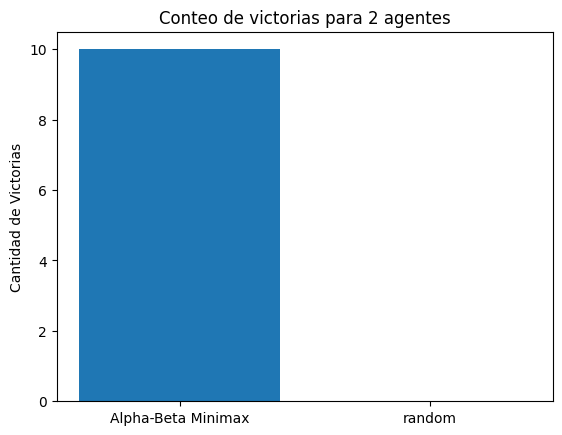

In [19]:
# Graficar los resultados
plot_win_count(win_rate_1, "Alpha-Beta Minimax", win_rate_2, "random", 10)

In [20]:
# Mostrar los resultados
win_rate_1, win_rate_2 = win_rate(evaluate("connectx", [minimax_agent_alpha_beta, "negamax"], num_episodes=10))
print("Taza de éxito para el agente Minimax Alpha-Beta: ", win_rate_1, "%")
print("Taza de éxito para el agente Aleatorio: ", win_rate_2, "%")

Taza de éxito para el agente Minimax Alpha-Beta:  100.0 %
Taza de éxito para el agente Aleatorio:  0.0 %


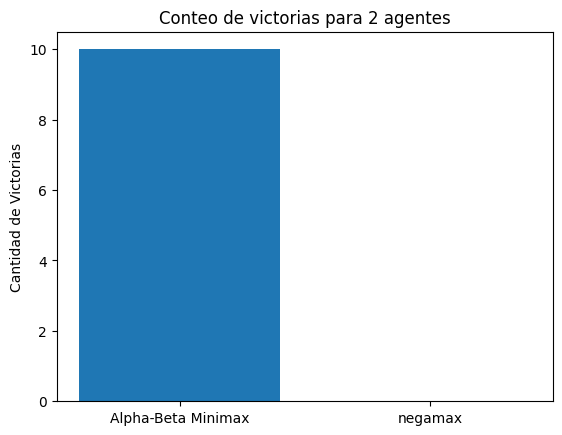

In [21]:
# Graficar los resultados
plot_win_count(win_rate_1, "Alpha-Beta Minimax", win_rate_2, "negamax", 10)